# Visualise and Cluster Abstracts

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from openai import OpenAI
import os
from scholarly import scholarly
from sklearn.decomposition import PCA
import requests
from time import sleep
from tqdm import tqdm
import json
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import textwrap

# Initialize OpenAI client
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

## ATLAS Test

In [24]:
data_directory = '../data'

df = pd.read_json(os.path.join(data_directory, 'atlas_data.json'))
df.head()

comment  \
0  All figures including auxiliary figures are av...   
1  All figures including auxiliary figures are av...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                             report_number  \
0  {'internal': 'ATLAS-COM-CONF-2024-032'}   
1  {'internal': 'ATLAS-COM-CONF-2024-023'}   
2    {'internal': 'ATL-COM-SOFT-2024-074'}   
3    {'internal': 'ATL-COM-SOFT-2024-067'}   
4    {'internal': 'ATL-COM-SOFT-2024-071'}   

                                            abstract        creation_date  \
0  Neural Simulation-Based Inference (NSBI) is a ...  2024-10-28T17:46:14   
1  Measurements of jet substructure are key to pr...  2024-07-30T17:01:34   
2  Simulation of the detector response is a major...  2024-10-28T23:20:08   
3  Neural Simulation-Based Inference (NSBI) is a ...  2024-10-28T22:16:35   
4  Particle flow reconstruction at colliders comb...  2024-10-28T22:12:56   

            imprint   owner    primary_report_number  \
0  {'date': '2024'}  PUBLIC      ATLAS-CONF-2024-015   
1  {'date': '2024'}  PUBLIC      ATLAS-CONF-2024-012   
2  {'date': '2024'}  PUBLIC  ATL-SOFT-SLIDE-2024-510   
3  {'date': '2024'}  PUBLIC  ATL-SOFT-SLIDE-2024-508   
4  {'date': '2024'}  PUBLIC  ATL-SOFT-SLIDE-2024-507   

                                                 oai  \
0  {'indicator': ['cerncds:FULLTEXT', 'cerncds:at...   
1  {'indicator': ['cerncds:FULLTEXT', 'cerncds:at...   
2  {'indicator': 'cerncds:FULLTEXT', 'value': 'oa...   
3  {'indicator': 'cerncds:FULLTEXT', 'value': 'oa...   
4  {'indicator': 'cerncds:FULLTEXT', 'value': 'oa...   

                                            keywords  \
0  [{'institute': 'CERN', 'term': 'Machine Learni...   
1  [{'institute': 'CERN', 'term': 'Jet Substructu...   
2                                                NaN   
3  [{'institute': 'CERN', 'term': 'neural simulat...   
4  [{'institute': 'CERN', 'term': 'Particle flow'...   

                                             subject  ...  \
0  {'source': 'SzGeCERN', 'term': 'Particle Physi...  ...   
1  {'source': 'SzGeCERN', 'term': 'Particle Physi...  ...   
2  {'source': 'SzGeCERN', 'term': 'Particle Physi...  ...   
3  {'source': 'SzGeCERN', 'term': 'Particle Physi...  ...   
4  {'source': 'SzGeCERN', 'term': 'Particle Physi...  ...   

                                status_week  \
0  {'status': 'n', 'status_week': '202470'}   
1  {'status': 'n', 'status_week': '202470'}   
2  {'status': 'n', 'status_week': '202470'}   
3  {'status': 'n', 'status_week': '202470'}   
4  {'status': 'n', 'status_week': '202470'}   

                                       email_message    recid filetypes  \
0  [{'address': 'aishik.ghosh@cern.ch'}, {'addres...  2915316     [pdf]   
1                {'address': 'jingjing.pan@cern.ch'}  2905858     [pdf]   
2                  {'address': 'corchia@bo.infn.it'}  2915361     [pdf]   
3  [{'address': 'aishik.ghosh@cern.ch'}, {'addres...  2915357     [pdf]   
4  [{'address': 'luca.clissa@cern.ch'}, {'address...  2915356     [pdf]   

                                      prepublication  \
0  {'date': '28 Oct 2024', 'place': 'Geneva', 'pu...   
1  {'date': '30 Jul 2024', 'place': 'Geneva', 'pu...   
2  {'date': '28 Oct 2024', 'place': 'Geneva', 'pu...   
3  {'date': '28 Oct 2024', 'place': 'Geneva', 'pu...   
4  {'date': '28 Oct 2024', 'place': 'Geneva', 'pu...   

                          system_control_number address agency_code license  \
0                                           NaN     NaN         NaN     NaN   
1  {'institute': 'Inspire', 'value': '2814773'}     NaN         NaN     NaN   
2                                           NaN     NaN         NaN     NaN   
3                                           NaN     NaN         NaN     NaN   
4                                           NaN     NaN         NaN     NaN   

  copyright_status  
0              NaN  
1 

In [16]:
# Function to get embeddings
def get_embeddings(texts):
    response = client.embeddings.create(
        input=texts,
        model="text-embedding-3-large"
    )
    return [np.array(embedding.embedding) for embedding in response.data]

In [17]:
# Get embeddings
embeddings = get_embeddings(df['abstract'].values)
df['embedding'] = embeddings
df.head()


comment  \
0  All figures including auxiliary figures are av...   
1  All figures including auxiliary figures are av...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                             report_number  \
0  {'internal': 'ATLAS-COM-CONF-2024-032'}   
1  {'internal': 'ATLAS-COM-CONF-2024-023'}   
2    {'internal': 'ATL-COM-SOFT-2024-074'}   
3    {'internal': 'ATL-COM-SOFT-2024-067'}   
4    {'internal': 'ATL-COM-SOFT-2024-071'}   

                                            abstract        creation_date  \
0  Neural Simulation-Based Inference (NSBI) is a ...  2024-10-28T17:46:14   
1  Measurements of jet substructure are key to pr...  2024-07-30T17:01:34   
2  Simulation of the detector response is a major...  2024-10-28T23:20:08   
3  Neural Simulation-Based Inference (NSBI) is a ...  2024-10-28T22:16:35   
4  Particle flow reconstruction at colliders comb...  2024-10-28T22:12:56   

            imprint   owner    primary_report_number  \
0  {'date': '2024'}  PUBLIC      ATLAS-CONF-2024-015   
1  {'date': '2024'}  PUBLIC      ATLAS-CONF-2024-012   
2  {'date': '2024'}  PUBLIC  ATL-SOFT-SLIDE-2024-510   
3  {'date': '2024'}  PUBLIC  ATL-SOFT-SLIDE-2024-508   
4  {'date': '2024'}  PUBLIC  ATL-SOFT-SLIDE-2024-507   

                                                 oai  \
0  {'indicator': ['cerncds:FULLTEXT', 'cerncds:at...   
1  {'indicator': ['cerncds:FULLTEXT', 'cerncds:at...   
2  {'indicator': 'cerncds:FULLTEXT', 'value': 'oa...   
3  {'indicator': 'cerncds:FULLTEXT', 'value': 'oa...   
4  {'indicator': 'cerncds:FULLTEXT', 'value': 'oa...   

                                            keywords  \
0  [{'institute': 'CERN', 'term': 'Machine Learni...   
1  [{'institute': 'CERN', 'term': 'Jet Substructu...   
2                                                NaN   
3  [{'institute': 'CERN', 'term': 'neural simulat...   
4  [{'institute': 'CERN', 'term': 'Particle flow'...   

                                             subject  ...  \
0  {'source': 'SzGeCERN', 'term': 'Particle Physi...  ...   
1  {'source': 'SzGeCERN', 'term': 'Particle Physi...  ...   
2  {'source': 'SzGeCERN', 'term': 'Particle Physi...  ...   
3  {'source': 'SzGeCERN', 'term': 'Particle Physi...  ...   
4  {'source': 'SzGeCERN', 'term': 'Particle Physi...  ...   

                                       email_message    recid filetypes  \
0  [{'address': 'aishik.ghosh@cern.ch'}, {'addres...  2915316     [pdf]   
1                {'address': 'jingjing.pan@cern.ch'}  2905858     [pdf]   
2                  {'address': 'corchia@bo.infn.it'}  2915361     [pdf]   
3  [{'address': 'aishik.ghosh@cern.ch'}, {'addres...  2915357     [pdf]   
4  [{'address': 'luca.clissa@cern.ch'}, {'address...  2915356     [pdf]   

                                      prepublication  \
0  {'date': '28 Oct 2024', 'place': 'Geneva', 'pu...   
1  {'date': '30 Jul 2024', 'place': 'Geneva', 'pu...   
2  {'date': '28 Oct 2024', 'place': 'Geneva', 'pu...   
3  {'date': '28 Oct 2024', 'place': 'Geneva', 'pu...   
4  {'date': '28 Oct 2024', 'place': 'Geneva', 'pu...   

                          system_control_number address agency_code license  \
0                                           NaN     NaN         NaN     NaN   
1  {'institute': 'Inspire', 'value': '2814773'}     NaN         NaN     NaN   
2                                           NaN     NaN         NaN     NaN   
3                                           NaN     NaN         NaN     NaN   
4                                           NaN     NaN         NaN     NaN   

  copyright_status                                          embedding  
0              NaN  [0.004124586936086416, -0.005306655541062355, ...  
1              NaN  [-0.030949518084526062, -0.013870754279196262,...  
2              NaN  [-0.033884380012750626, 0.005522151477634907, ...  
3              NaN  [0.0063842432573437

In [21]:
# tsne 2d visualization of embeddings with K-means clustering
# Convert embeddings to a 2D numpy array
embeddings_array = np.array(df["embedding"].tolist())

# Perform t-SNE
n_samples = len(embeddings_array)
perplexity = min(30, n_samples - 3)  # Default is 30, ensure it's less than n_samples
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
embedding_2d = tsne.fit_transform(embeddings_array)

# Perform K-means clustering
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_array)

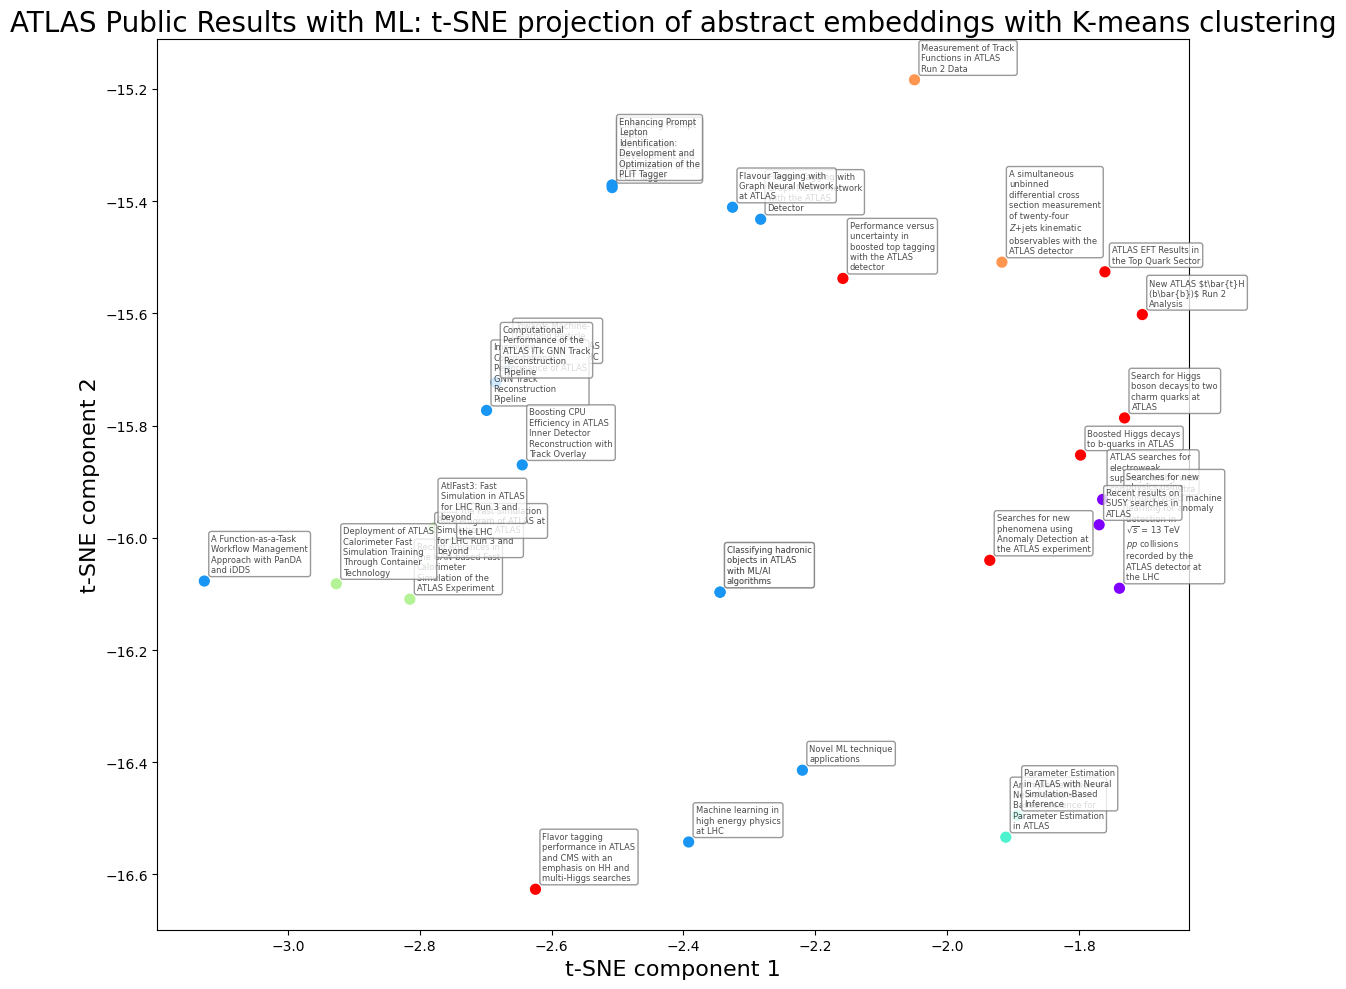

Number of clusters: 6


In [23]:
# Add 2D embeddings and cluster labels to the dataframe
df["embedding_2d_x"] = embedding_2d[:, 0]
df["embedding_2d_y"] = embedding_2d[:, 1]
df["cluster"] = cluster_labels

# Generate a discrete colormap
colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))
cmap = ListedColormap(colors)

# # Create a high-resolution figure
# plt.figure(figsize=(24, 20), dpi=600)

# Create a low-resolution figure
plt.figure(figsize=(12, 10))

# Plot the embeddings
scatter = plt.scatter(df["embedding_2d_x"], df["embedding_2d_y"], c=df["cluster"], cmap=cmap, s=50)
plt.title("ATLAS Public Results with ML: t-SNE projection of abstract embeddings with K-means clustering", fontsize=20)
plt.xlabel("t-SNE component 1", fontsize=16)
plt.ylabel("t-SNE component 2", fontsize=16)

# Add titles as annotations with text wrapping
for i, title in enumerate(df["title"]):
    wrapped_title = textwrap.fill(title, width=20)  # Adjust width as needed
    plt.annotate(wrapped_title, (df["embedding_2d_x"][i], df["embedding_2d_y"][i]), 
                 fontsize=6, alpha=0.7, 
                 xytext=(5, 5), textcoords='offset points',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
                 ha='left', va='bottom')

plt.tight_layout()
# plt.savefig('tsne_kmeans_clustering_high_res.png', dpi=600, bbox_inches='tight')
plt.show()

# Print the number of clusters
print(f"Number of clusters: {n_clusters}")


## Combined Results

In [3]:
data_directory = '../data'

df = pd.read_json(os.path.join(data_directory, 'lhc_combined_data.json'))
print(len(df))
df.head()

129


report_number  \
0  {'internal': 'ATL-COM-PHYS-2024-871'}   
1  {'internal': 'ATL-COM-SOFT-2024-074'}   
2  {'internal': 'ATL-COM-SOFT-2024-067'}   
3  {'internal': 'ATL-COM-SOFT-2024-071'}   
4  {'internal': 'ATL-COM-SOFT-2024-072'}   

                                            abstract        creation_date  \
0  Due to its large mass, the top quark plays a c...  2024-10-29T18:50:22   
1  Simulation of the detector response is a major...  2024-10-28T23:20:08   
2  Neural Simulation-Based Inference (NSBI) is a ...  2024-10-28T22:16:35   
3  Particle flow reconstruction at colliders comb...  2024-10-28T22:12:56   
4  Track reconstruction is an essential element o...  2024-10-28T21:00:54   

            imprint   owner    primary_report_number  \
0  {'date': '2024'}  PUBLIC   ATL-PHYS-PROC-2024-099   
1  {'date': '2024'}  PUBLIC  ATL-SOFT-SLIDE-2024-510   
2  {'date': '2024'}  PUBLIC  ATL-SOFT-SLIDE-2024-508   
3  {'date': '2024'}  PUBLIC  ATL-SOFT-SLIDE-2024-507   
4  {'date': '2024'}  PUBLIC  ATL-SOFT-SLIDE-2024-499   

                                                 oai  \
0  {'indicator': 'cerncds:FULLTEXT', 'value': 'oa...   
1  {'indicator': 'cerncds:FULLTEXT', 'value': 'oa...   
2  {'indicator': 'cerncds:FULLTEXT', 'value': 'oa...   
3  {'indicator': 'cerncds:FULLTEXT', 'value': 'oa...   
4  {'indicator': 'cerncds:FULLTEXT', 'value': 'oa...   

                                            keywords  \
0  [{'institute': 'CERN', 'term': 'SUSY'}, {'inst...   
1                                                NaN   
2  [{'institute': 'CERN', 'term': 'neural simulat...   
3  [{'institute': 'CERN', 'term': 'Particle flow'...   
4  [{'institute': 'CERN', 'term': 'Track Reconstr...   

                                             subject  \
0  {'source': 'SzGeCERN', 'term': 'Particle Physi...   
1  {'source': 'SzGeCERN', 'term': 'Particle Physi...   
2  {'source': 'SzGeCERN', 'term': 'Particle Physi...   
3  {'source': 'SzGeCERN', 'term': 'Particle Physi...   
4  {'source': 'SzGeCERN', 'term': 'Particle Physi...   

        physical_description  ...  system_control_number address agency_code  \
0      {'pagination': '6 p'}  ...                    NaN     NaN         NaN   
1      {'pagination': '1 p'}  ...                    NaN     NaN         NaN   
2  {'pagination': 'mult. p'}  ...                    NaN     NaN         NaN   
3  {'pagination': 'mult. p'}  ...                    NaN     NaN         NaN   
4     {'pagination': '18 p'}  ...                    NaN     NaN         NaN   

  funding_info publication_info license copyright_status  doi  url  \
0          NaN              NaN     NaN              NaN  NaN  NaN   
1          NaN              NaN     NaN              NaN  NaN  NaN   
2          NaN              NaN     NaN              NaN  NaN  NaN   
3          NaN              NaN     NaN              NaN  NaN  NaN   
4          NaN              NaN     NaN              NaN  NaN  NaN   

  title_additional  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  

[5 rows x 47 columns]

In [57]:
# Function to get embeddings
def get_embeddings(texts):
    response = client.embeddings.create(
        input=texts,
        model="text-embedding-3-large"
    )
    return [np.array(embedding.embedding) for embedding in response.data]

In [58]:
# Get embeddings
embeddings = get_embeddings(df['abstract'].values)
df['embedding'] = embeddings


In [59]:
# tsne 2d visualization of embeddings with K-means clustering
# Convert embeddings to a 2D numpy array
embeddings_array = np.array(df["embedding"].tolist())

# Perform t-SNE
n_samples = len(embeddings_array)
perplexity = min(30, n_samples - 3)  # Default is 30, ensure it's less than n_samples
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
embedding_2d = tsne.fit_transform(embeddings_array)

# Perform K-means clustering
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_array)

In [65]:
# Save to file the 2d embeddings and cluster labels
np.savez(os.path.join(data_directory, 'lhc_combined_data_2d_embeddings.npz'), embedding_2d=embedding_2d, cluster_labels=cluster_labels)

In [6]:
# Load the 2d embeddings and cluster labels
n_clusters = 6
data = np.load(os.path.join(data_directory, 'lhc_combined_data_2d_embeddings.npz'))
embedding_2d = data['embedding_2d']
cluster_labels = data['cluster_labels']


In [7]:
# Add 2D embeddings and cluster labels to the dataframe
df["embedding_2d_x"] = embedding_2d[:, 0]
df["embedding_2d_y"] = embedding_2d[:, 1]
df["cluster"] = cluster_labels

# Generate a discrete colormap
colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))
cmap = ListedColormap(colors)

# # Create a high-resolution figure
plt.figure(figsize=(24, 20), dpi=600)

# Create a low-resolution figure
# plt.figure(figsize=(12, 10))

# Plot the embeddings, with shape of marker based on experiment [ATLAS, CMS, LHCb, ALICE]
if "experiment" in df.columns:
    markers = {
        "ATLAS": "o",
        "CMS": "s",
        "LHCb": "D",
        "ALICE": "X",
        "NaN": "o"
    }
    
    # Plot each experiment separately
    for experiment, marker in markers.items():
        mask = df["experiment"] == experiment
        if mask.any():
            plt.scatter(
                df.loc[mask, "embedding_2d_x"], 
                df.loc[mask, "embedding_2d_y"],
                c=df.loc[mask, "cluster"],
                cmap=cmap,
                s=50,
                marker=marker,
                label=experiment
            )
    
    # Plot points with NaN experiment
    mask = df["experiment"].isna()
    if mask.any():
        plt.scatter(
            df.loc[mask, "embedding_2d_x"],
            df.loc[mask, "embedding_2d_y"],
            c=df.loc[mask, "cluster"],
            cmap=cmap,
            s=50,
            marker=".",
            label="Unknown"
        )
    
    plt.legend()
    
plt.title("Combined LHC Public Results with ML: t-SNE projection of abstract embeddings with K-means clustering", fontsize=20)
plt.xlabel("t-SNE component 1", fontsize=16)
plt.ylabel("t-SNE component 2", fontsize=16)

# Add titles as annotations with text wrapping
for i, title in enumerate(df["title"]):
    wrapped_title = textwrap.fill(title, width=20)  # Adjust width as needed
    plt.annotate(wrapped_title, (df["embedding_2d_x"][i], df["embedding_2d_y"][i]), 
                 fontsize=6, alpha=0.7, 
                 xytext=(5, 5), textcoords='offset points',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
                 ha='left', va='bottom')

plt.tight_layout()
# Save as pdf with high resolution
plt.savefig('tsne_kmeans_clustering_high_res.pdf', dpi=600, bbox_inches='tight')
plt.show()

# Print the number of clusters
print(f"Number of clusters: {n_clusters}")


Number of clusters: 6


In [62]:
df.experiment.unique()

array(['ATLAS', 'ALICE,ATLAS,CMS,LHCB', 'Not applicable', 'CMS', 'LHCb',
       'No experiment', 'ALICE'], dtype=object)